<a href="https://colab.research.google.com/github/brittdecker/Review/blob/master/Kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kalman Filter Example


Example Goal: 

1) Create position vector over time

2) Add noise

3) run through the Kalman filter to predict next location

4) calculate the error of the fiter predictions

x̂N,N=1N(z1+z2+…+zN−1+zN)=1N∑n=1N(zn)

Notation:

xis the true value of the weight

zn is the measurement value of the weight at time n x̂n,

n is the estimate of x at time n (the estimate is made after taking the measurement zn)

x̂n,n−1 is the previous estimate of x that was made at time n−1 (the estimate was made after taking the measurement zn−1)

x̂n+1,n is the estimate of the future state (n+1) of x. The estimate is made at the time n, right after the measurement zn. In other words, xn+1,n is a predicted state


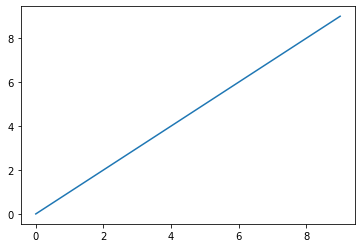

In [38]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import math
from scipy.stats import rv_discrete


def generate_positions(t,x,y,x_v,y_v):

  coord = {}
  coord['x'] = []
  coord['y'] = []
  coord['time'] = []

  for step in range(t):
    coord['x'].append(x_v*step + x)
    coord['y'].append(y_v*step + y)
    coord['time'].append(step)


  return coord

#for x, y at (0, 0), generate truth positions for 10 sec worth data for vel = 1 m/s
coordinates = generate_positions(10,0,0,1,1)  

plt.plot(coordinates['x'],coordinates['y'])



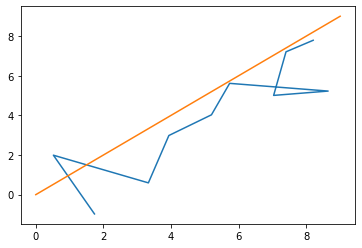

In [56]:
def measure(data, noise, time):
  AWGN = stats.norm(0, 1)
  noise = AWGN.rvs()

  sample = data[time] + noise

  return sample

x_sampled = []
y_sampled = []

for step in coordinates['time']:
  x_sampled.append(measure(coordinates['x'],0,step))
  y_sampled.append(measure(coordinates['y'],0,step))

plt.plot(x_sampled,y_sampled)

plt.plot(coordinates['x'],coordinates['y'])




{'pos': [1.4161799311658252, 2.0155003075409836, 3.459071952806541, 4.315515701480837, 5.680012698475941, 6.429378465612026, 8.233510793411316, 8.49721188655977, 9.539092869375946, 9.805583754029911], 'vel': [1.0, 1.0, 0.7785113798168672, 1.180875574660766, 0.7612608302643259, 1.1887262875697902, 0.7389213171951932, 1.3610894496370793, 0.5038476838324828, 1.261576267158879, 0.5338293988194576]}


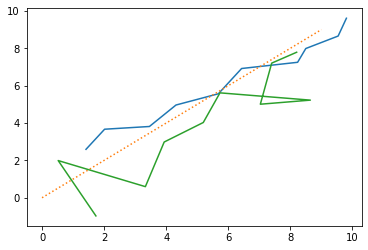

In [61]:
initial_state = [coordinates['x'][0],coordinates['y'][0]]

def meas_vel(delta_time, pos, prev_pos):

  vel = (pos - prev_pos)/delta_time

  return vel

def delta_t(time, prev_time):

  dt = time - prev_time

  return dt

def kalman_filter(delta_time, pos_meas, vel_meas, pos_pred, vel_pred):

  alpha = 0.2
  beta = 0.1

  next_pos = pos_pred + alpha*(pos_meas - pos_pred)

  next_vel = vel_pred + beta*((vel_meas - vel_pred)/delta_time)

  next_pos = next_pos + delta_time*next_vel

  return next_pos, next_vel

x_pred = {}
y_pred = {}
x_pred['pos'] = []
y_pred['pos'] = []
x_pred['vel'] = []
y_pred['vel'] = []

x_pred['vel'].append(meas_vel(coordinates['time'][1],coordinates['x'][1],coordinates['x'][0]))
y_pred['vel'].append(meas_vel(coordinates['time'][1],coordinates['y'][1],coordinates['y'][0]))

#Initialize filter
#For init, use meas = true, and sampled - true for pred
xvel_meas = meas_vel(coordinates['time'][1],coordinates['x'][1],coordinates['x'][0])
yvel_meas = meas_vel(coordinates['time'][1],coordinates['y'][1],coordinates['y'][0])
xpos, xvel = kalman_filter(coordinates['time'][1],coordinates['x'][0], xvel_meas, x_sampled[1], x_pred['vel'][0])
ypos, yvel = kalman_filter(coordinates['time'][1],coordinates['y'][0], yvel_meas, y_sampled[1], y_pred['vel'][0])
x_pred['pos'].append(xpos)
x_pred['vel'].append(xvel)
y_pred['pos'].append(ypos)
y_pred['vel'].append(yvel)



for i in range(1, len(x_sampled)):
  dt = delta_t(coordinates['time'][i],coordinates['time'][i-1])

  xvel_meas = meas_vel(dt,x_sampled[i],x_sampled[i-1])
  yvel_meas = meas_vel(dt,y_sampled[i],y_sampled[i-1])

  xpos, xvel = kalman_filter(dt,x_sampled[i], xvel_meas, x_pred['pos'][i-1], x_pred['vel'][i-1])
  ypos, yvel = kalman_filter(dt,y_sampled[i], yvel_meas, y_pred['pos'][i-1], y_pred['vel'][i-1])

  x_pred['pos'].append(xpos)
  x_pred['vel'].append(xvel)
  y_pred['pos'].append(ypos)
  y_pred['vel'].append(yvel)

print(x_pred)


#filter output
plt.plot(x_pred['pos'],y_pred['pos'], '-')
#ground truth
plt.plot(coordinates['x'],coordinates['y'], ':')
#noisy measurements
plt.plot(x_sampled,y_sampled, '-')


